In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 3)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Dense, Flatten, Conv2D, MaxPool2D
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tqdm import tqdm
import matplotlib.pyplot as plt

#from cleverhans.future.tf2.attacks import projected_gradient_descent, fast_gradient_method

import foolbox as fb
#import foolbox.ext.native as fbn
import eagerpy as ep
#from foolbox import TensorFlowModel, accuracy, samples
import foolbox.attacks as fa
import numpy as np
np.set_printoptions(suppress=True)

/home/florian/anaconda2/envs/master-thesis/lib/python3.8/site-packages/foolbox/attacks/brendel_bethge.py:781: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass(spec=[])
/home/florian/anaconda2/envs/master-thesis/lib/python3.8/site-packages/foolbox/attacks/brendel_bethge.py:1358: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  @jitclass(spec=spec)
/home/florian/anaconda2/envs/master-thesis/lib/python

In [87]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#print(x_train[:100])
x_train = (x_train.reshape(60000, 784).astype('float32') / 255)
x_test = (x_test.reshape(10000, 784).astype('float32') / 255)
#x = tf.convert_to_tensor(tf.expand_dims(x_train[:100].reshape(28,28,1), axis=0), tf.float32)
x = tf.convert_to_tensor(x_train[:35].reshape(35,28,28,1))
y = tf.convert_to_tensor([y_train[:35]])[0];


In [88]:
#model = tf.keras.models.load_model('../saved-models/attack-test-model')
fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))

In [94]:
res = []
lrs = [1e1,1e3, 1e5, 1e7, 1e9, 1e11, 1e13,1e15]
for lr in lrs:

    fmodel = fb.models.TensorFlowModel(model, bounds=(0,1))
    attack = fb.attacks.L0BrendelBethgeAttack(steps = 1000, lr=lr, binary_search_steps=100)
    advs, clipped_advs, success = attack(
        fmodel,
        x,
        y,
        epsilons=[None]
    )
    if all(list(success.numpy()[0])):
        sum_of_dist = 0
        l0_dist = np.sum([np.count_nonzero(x[i]-advs[0][i]) for i in range(35)])
        res.append(l0_dist)
    else:
        print('not sucessful', lr)
    

In [93]:
print(res)

[43, 46, 47, 31, 37, 49, 36, 36]


In [95]:
print([x/35 for x in res])

[30.6, 18.857142857142858, 13.257142857142858, 15.8, 14.314285714285715, 15.342857142857143, 13.771428571428572, 14.657142857142857]


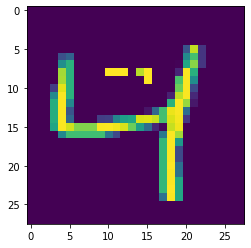

In [58]:
plt.imshow(tf.reshape(advs[0][2], (28,28)))
#plt.show()

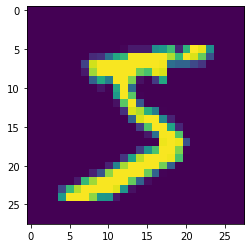

In [20]:
plt.imshow(tf.reshape(x[0], (28,28)))


In [25]:
advs[0][0]

<tf.Tensor: shape=(28, 28, 1), dtype=float32, numpy=
array([[[0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.18393044],
        [0.22288385],
        [0.        ],
        [0.        ],
        [0.2324681 ],
        [0.        ],
        [0.19526619],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.21340184],
        [0.        ]],

       [[0.        ],
        [0.18813065],
        [0.        ],
        [0.        ],
        [0.19999252],
        [0.1832843 ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ],

In [4]:
shapes = {
    # 5x5 conv, 1 input, 6 outputs
    'conv_1': (5, 5, 1, 6),
    # 5x5 conv, 6 inputs, 16 outputs
    'conv_2': (5, 5, 6, 16),
    #5x5 conv as in paper, 16 inputs, 120 outputs
    'conv_3': (1, 1, 16, 120),
    # fully connected, 5*5*16 inputs, 120 outputs
    'dense_1': (5*5*16, 120),
    # fully connected, 120 inputs, 84 outputs
    'dense_2': (120, 84),
    # 84 inputs, 10 outputs (class prediction)
    'dense_3': (84, 10),
}
bias_shapes = {
    #output depth
    'conv_1': (6),
    'conv_2': (16),
    'dense_1': (120),
    'dense_2': (84),
    'dense_3': (10),
}

#conv2D with bias and relu activation

class CustomConvLayer(layers.Layer):

    def __init__(self, weights, mask, biases, strides, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = weights
        self.m = mask
        self.b = biases
        self.s = strides
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, tf.multiply(self.w, self.m), strides=[1, self.s, self.s, 1], padding=self.p,)# data_format='NCHW')
        x = tf.nn.bias_add(x, self.b,)# 'NC...')
        return tf.nn.tanh(x)
        

#Average Pooling Layer
class CustomPoolLayer(layers.Layer):
    
    def __init__(self, k=2, padding='valid'):#padding='VALID'):
        super(CustomPoolLayer, self).__init__()
        self.k = k
        self.p = padding
    
    def call(self, inputs):
#        return tf.keras.layers.AveragePooling2D(pool_size=(self.k, self.k), strides=None, padding=self.p, data_format='channels_first')(inputs)
        return tf.nn.avg_pool2d(inputs, ksize=[1, self.k, self.k,1], strides=[1, self.k, self.k, 1], padding=self.p,)# data_format='NCHW')
    

        
class CustomConvLayer(layers.Layer):

    def __init__(self, shape, bias, strides, padding='SAME'):
        
        super(CustomConvLayer, self).__init__()
        self.w = self.add_weight(
            shape=shape,
            initializer='random_normal',
            trainable=True,
            name='w'
        )
        self.m = self.add_weight(
            shape=shape,
            initializer='ones',
            trainable=False,
            name='m'
        )
        self.b = self.add_weight(
            shape = (shape[-1]),
            initializer = 'zeros',
            trainable = True,
            name='b'
        )
        self.s = strides
        self.p = padding

        
    def call(self, inputs):
        x = tf.nn.conv2d(inputs, tf.multiply(self.w, self.m), strides=[1, self.s, self.s, 1], padding=self.p,)# data_format='NCHW')
        x = tf.nn.bias_add(x, self.b,)# 'NC...')
        return tf.nn.tanh(x)

#Dense Layer with Bias
class CustomDenseLayer(layers.Layer):
    def __init__(self, shape, bias, activation = 'tanh'):
        super(CustomDenseLayer, self).__init__()
        self.w = self.add_weight(
            shape = shape,
            initializer='random_normal',
            trainable = True,
            name='w'
        )
        self.m = self.add_weight(
            shape = shape,
            initializer='ones',
            trainable = False,
            name='m'
        )
        self.b = self.add_weight(
            shape = (shape[-1]),
            initializer = 'zeros',
            trainable = True,
            name='b'
        )
        self.a = activation
        
        
    def call(self, inputs):
        x = tf.matmul(inputs, tf.multiply(self.w, self.m))
        x = tf.nn.bias_add(x, self.b)
        if self.a == 'tanh':
            return tf.nn.tanh(x)
        if self.a == 'softmax':
            return tf.nn.softmax(x)
        if self.a == None:
            return x
        
        
        
class CustomConvModel(tf.keras.Model):
    def __init__(self):
        super(CustomConvModel, self).__init__()
        self.conv1 = CustomConvLayer(shapes['conv_1'], True, 1, 'SAME')#'VALID')
        self.maxpool1 = CustomPoolLayer(k=2, padding='SAME')
        self.conv2 = CustomConvLayer(shapes['conv_2'], True, 1, 'VALID')
        self.maxpool2 = CustomPoolLayer(k=2, padding='VALID')

        self.dense1 = CustomDenseLayer(shapes['dense_1'], True, 'tanh')
        self.dense2 = CustomDenseLayer(shapes['dense_2'], True, 'tanh')
        self.dense3 = CustomDenseLayer(shapes['dense_3'], True, None)
        self.pre_softmax = None
        
    def call(self, inputs):
        x = tf.reshape(inputs, shape=[-1,28, 28, 1])
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = layers.Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x =  self.dense3(x)
        self.pre_softmax = x
        return tf.nn.softmax(x)
    
    def prune_random_local_unstruct(self, ratio):
        def prune_conv_layers_locally(self, ratio):
            conv_layer_to_prune = [0, 3]
            weights = self.get_weights()
            for layer in conv_layer_to_prune:
                converted_weights = convert_from_hwio_to_iohw(weights[layer]).numpy()
                converted_mask = convert_from_hwio_to_iohw(weights[layer + 2]).numpy()
                for input_index, input_layer in enumerate(converted_weights):
                    for kernel_index, kernel in enumerate(input_layer):
                        shape = kernel.shape
                        flat_weights = kernel.flatten()
                        flat_masks = converted_mask[input_index][kernel_index].flatten()
                        
                        no_of_weighs_to_prune = ratio * len(flat_weights)
                        # find unpruned weights
                        non_zero_weights = np.nonzero(flat_masks)[0]
                        # calculate the amount of weights to be pruned this round
                        no_of_weights_to_prune_left = int(no_of_weighs_to_prune - (len(flat_weights) - len(non_zero_weights)) )
                        # shuffle all non-zero weights
                        random.shuffle(non_zero_weights)
                        # and take the indices of the first x weights where x is the number of weights to be pruned this round
                        indices_to_delete = non_zero_weights[:no_of_weights_to_prune_left]
                        
                        for idx_to_delete in indices_to_delete:
                            flat_masks[idx_to_delete] = 0
                            flat_weights[idx_to_delete] = 0
                        converted_mask[input_index][kernel_index] = flat_masks.reshape(shape)
                        converted_weights[input_index][kernel_index] = flat_weights.reshape(shape)
                back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
                back_converted_weights = convert_from_iohw_to_hwio(converted_weights)
                weights[layer] = back_converted_weights
                weights[layer+2] = back_converted_mask
            self.set_weights(weights)
            return True
        
        def prune_dense_layers_locally(self, ratio):
            dense_layer_to_prune = [6, 9, 12]
            weights = self.get_weights()
            for index, weight in enumerate(weights):
                if index in dense_layer_to_prune:
                    shape = weight.shape
                    flat_weights = weight.flatten()
                    flat_mask = weights[index+2].flatten()
                    no_of_weighs_to_prune = ratio * len(flat_weights)
                    # find unpruned weights
                    non_zero_weights = np.nonzero(flat_mask)[0]
                    # calculate the amount of weights to be pruned this round
                    no_of_weights_to_prune_left = int(no_of_weighs_to_prune - (len(flat_weights) - len(non_zero_weights)) )
                    # shuffle all non-zero weights
                    random.shuffle(non_zero_weights)
                    # and take the indices of the first x weights where x is the number of weights to be pruned this round
                    indices_to_delete = non_zero_weights[:no_of_weights_to_prune_left]
                    for idx_to_delete in indices_to_delete:
                        flat_mask[idx_to_delete] = 0
                        flat_weights[idx_to_delete] = 0

                    mask_reshaped = flat_mask.reshape(shape)
                    weights_reshaped = flat_weights.reshape(shape)
                    weights[index+2] = mask_reshaped
                    weights[index] = weights_reshaped
            self.set_weights(weights)
            return True
        prune_conv_layers_locally(self, ratio)
        prune_dense_layers_locally(self,ratio)
    
    def prune_magnitude_global_unstruct(self, ratio):
        #flat out all weights:
        conv_layer_to_prune = [0, 3]
        dense_layer_to_prune = [6, 9, 12]
        weights = self.get_weights()
        flat_weights = []
        flat_mask = []
        for x in conv_layer_to_prune + dense_layer_to_prune:
            flat_weights = np.append(flat_weights, weights[x])
            flat_mask = np.append(flat_mask, weights[x+2])
            
        no_of_weights_to_prune = int(len(flat_weights)*ratio)
        indices_to_delete = np.abs(flat_weights).argsort(0)[:no_of_weights_to_prune]
        
        for idx_to_delete in indices_to_delete:
            flat_mask[idx_to_delete] = 0
            flat_weights[idx_to_delete] = 0
        z = 0
        for x in conv_layer_to_prune + dense_layer_to_prune:
            weights[x] = flat_weights[z:z + np.prod(weights[x].shape)].reshape(weights[x].shape)
            weights[x + 2] = flat_mask[z:z + np.prod(weights[x].shape)].reshape(weights[x].shape)
            z = z + np.prod(weights[x].shape)            
        self.set_weights(weights)
        
        
            
        
        
    
    def prune_magnitude_local_unstruct(self, ratio):
        def prune_conv_layers_locally(self, ratio):
            conv_layer_to_prune = [0, 3]
            #print('inside conv prune func',get_zeros_ratio(self.get_weights()))
            weights = self.get_weights()
            
            for layer in conv_layer_to_prune:
                converted_weights = convert_from_hwio_to_iohw(weights[layer]).numpy()
                converted_mask = convert_from_hwio_to_iohw(weights[layer + 2]).numpy()
                for input_index, input_layer in enumerate(converted_weights):
                    for kernel_index, kernel in enumerate(input_layer):
                        shape = kernel.shape
                        flat_weights = kernel.flatten()
                        flat_masks = converted_mask[input_index][kernel_index].flatten()
                        #flat_weights_df = pd.DataFrame(flat_weights)
                        #flat_mask_df = pd.DataFrame(flat_masks)
                        no_of_weights_to_prune = int(len(flat_weights)*ratio)
                        #print(no_of_weights_to_prune)
                        #indices_to_delete = flat_weights_df.abs().values.argsort(0)[:no_of_weights_to_prune]
                        indices_to_delete = np.abs(flat_weights).argsort(0)[:no_of_weights_to_prune]


                        for idx_to_delete in indices_to_delete:
                            flat_masks[idx_to_delete] = 0
                            flat_weights[idx_to_delete] = 0

                        converted_mask[input_index][kernel_index] = flat_masks.reshape(shape)
                        converted_weights[input_index][kernel_index] = flat_weights.reshape(shape)
                back_converted_mask = convert_from_iohw_to_hwio(converted_mask)
                back_converted_weights = convert_from_iohw_to_hwio(converted_weights)
                weights[layer] = back_converted_weights
                weights[layer+2] = back_converted_mask
            self.set_weights(weights)
            return True
        
        def prune_dense_layers_locally(self, ratio):
            
            dense_layer_to_prune = [6, 9, 12]
            weights = self.get_weights()
            for index, weight in enumerate(weights):
                if index in dense_layer_to_prune:
                    shape = weight.shape
                    flat_weights = weight.flatten()
                    flat_mask = weights[index+2].flatten()

                    no_of_weights_to_prune = int(len(flat_weights)*ratio)
                    indices_to_delete = np.abs(flat_weights).argsort()[:no_of_weights_to_prune]
                    for idx_to_delete in indices_to_delete:
                        flat_mask[idx_to_delete] = 0
                        flat_weights[idx_to_delete] = 0
                    mask_reshaped = flat_mask.reshape(shape)
                    weights_reshaped = flat_weights.reshape(shape)
                    weights[index+2] = mask_reshaped
                    weights[index] = weights_reshaped
            self.set_weights(weights)
            return True
        prune_conv_layers_locally(self,ratio)
        prune_dense_layers_locally(self,ratio)
        return
    
    def prune_random_local_struct(self, ratio):
        def prune_conv_layers(conv_layers_to_prune, weights):
            for x in conv_layers_to_prune:

                vals = []
                iohw_weights = convert_from_hwio_to_iohw(weights[x])
                iohw_mask = convert_from_hwio_to_iohw(weights[x+2])
                converted_shape = iohw_weights.shape
                no_of_channels = converted_shape[0]*converted_shape[1]
                no_of_channels_to_prune = int(np.round(ratio * no_of_channels))
                channels = tf.reshape(iohw_weights, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                #print(channels)
                non_zero_channels = np.nonzero([np.sum(channel) for channel in channels])[0]
                #print(non_zero_channels)
                no_of_channels_to_prune_left = no_of_channels_to_prune - (len(channels) - len(non_zero_channels))
                random.shuffle(non_zero_channels)
                channels_to_prune = non_zero_channels[:no_of_channels_to_prune_left]
                mask = tf.reshape(iohw_mask, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()

                for channel_to_prune in channels_to_prune:
                    channels[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])
                    mask[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])

                reshaped_mask = tf.reshape(mask, converted_shape)
                reshaped_weights = tf.reshape(channels, converted_shape)
                weights[x] = convert_from_iohw_to_hwio(reshaped_weights)
                weights[x+2] = convert_from_iohw_to_hwio(reshaped_mask)
            #self.set_weights(weights)
            return True
        def prune_dense_layers(dense_layers_to_prune, weights):
            for layer_to_prune in dense_layers_to_prune:
                rows = weights[layer_to_prune]
                no_of_rows_to_prune = int(ratio * len(weights[layer_to_prune]))
                non_zero_rows = np.nonzero([np.sum(row) for row in rows])[0]
                no_of_rows_to_prune_left = no_of_rows_to_prune - (len(rows) - len(non_zero_rows))
                random.shuffle(non_zero_rows)
                rows_to_prune = non_zero_rows[:no_of_rows_to_prune_left]
                
                for row_to_prune in rows_to_prune:
                    weights[layer_to_prune][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
                    weights[layer_to_prune+2][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
            return True
        weights = self.get_weights()
        conv_layers_to_prune = [0,3]
        dense_layers_to_prune = [6,9,12]
        prune_conv_layers(conv_layers_to_prune, weights)
        prune_dense_layers(dense_layers_to_prune, weights)
        self.set_weights(weights)
        return True

    def prune_random_global_struct(self, ratio):
        raise Warning('Not yet implemented')
        return False
    def prune_magnitude_local_struct(self, ratio):
        def prune_conv_layers(conv_layers_to_prune, weights):
            for x in conv_layers_to_prune:

                vals = []
                iohw_weights = convert_from_hwio_to_iohw(weights[x])
                iohw_mask = convert_from_hwio_to_iohw(weights[x+2])
                converted_shape = iohw_weights.shape
                no_of_channels = converted_shape[0]*converted_shape[1]
                no_of_channels_to_prune = int(np.round(ratio * no_of_channels))
                channels = tf.reshape(iohw_weights, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                
                mask = tf.reshape(iohw_mask, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                for channel in channels:
                    vals.append(tf.math.reduce_sum(tf.math.abs(channel)))
                channels_to_prune = np.argsort(vals)[:no_of_channels_to_prune]

                for channel_to_prune in channels_to_prune:
                    channels[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])
                    mask[channel_to_prune] = tf.zeros([converted_shape[2],converted_shape[3]])

                reshaped_mask = tf.reshape(mask, converted_shape)
                reshaped_weights = tf.reshape(channels, converted_shape)
                weights[x] = convert_from_iohw_to_hwio(reshaped_weights)
                weights[x+2] = convert_from_iohw_to_hwio(reshaped_mask)
            #self.set_weights(weights)
            return weights
        def prune_dense_layers(dense_layers_to_prune, weights):
            for layer_to_prune in dense_layers_to_prune:
                no_of_rows_to_prune = int(ratio * len(weights[layer_to_prune]))
                vals = []
                for row in weights[layer_to_prune]:
                    vals.append(np.sum(np.abs(row)))
                rows_to_prune = np.argsort(vals)[:no_of_rows_to_prune]
                for row_to_prune in rows_to_prune:

                    weights[layer_to_prune][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
                    weights[layer_to_prune+2][row_to_prune] = tf.zeros(len(weights[layer_to_prune][row_to_prune]))
            return weights
        weights = self.get_weights()
        conv_layers_to_prune = [0,3]
        dense_layers_to_prune = [6,9,12]
        weights = prune_conv_layers(conv_layers_to_prune, weights)
        weights = prune_dense_layers(dense_layers_to_prune, weights)
        self.set_weights(weights)
        return True
        
    def prune_magnitude_global_struct(self, ratio):
        def prune_conv_layers(conv_layers_to_prune, weights):
            all_channels = np.empty((0,5,5))
            original_shapes = []
            for layer_to_prune in conv_layers_to_prune:
                iohw_weights = convert_from_hwio_to_iohw(weights[layer_to_prune])
                converted_shape = iohw_weights.shape
                no_of_channels = converted_shape[0]*converted_shape[1]
                channels = tf.reshape(iohw_weights, (no_of_channels,converted_shape[2],converted_shape[3])).numpy()
                all_channels = np.concatenate((all_channels, channels))
            mask = np.ones(all_channels.shape)
            vals = [np.sum(np.abs(channel)) for channel in all_channels]
            no_of_channels_to_prune = int(ratio * len(vals))
            channels_to_prune = np.argsort(vals)[:no_of_channels_to_prune]

            for channel_to_prune in channels_to_prune:
                all_channels[channel_to_prune] = tf.zeros((5,5))
                mask[channel_to_prune] = tf.zeros((5,5))
            z = 0
            for i, layer_to_prune in enumerate(conv_layers_to_prune):
                original_shape = convert_from_hwio_to_iohw(weights[layer_to_prune]).shape
                pruned_layer = tf.reshape(all_channels[z:z + original_shape[0]*original_shape[1]], original_shape)
                pruned_mask = tf.reshape(mask[z:z + original_shape[0]*original_shape[1]], original_shape)
                weights[layer_to_prune] = convert_from_iohw_to_hwio(pruned_layer)
                weights[layer_to_prune + 2] = convert_from_iohw_to_hwio(pruned_mask)
                z = original_shape[0]*original_shape[1]    
            return weights
        
        def prune_dense_layers(dense_layers_to_prune, weights):
            vals = []
            lengths = []
            for layer_to_prune in dense_layers_to_prune:
                lengths.append(weights[layer_to_prune].shape[0])
                vals = vals + [np.sum(np.abs(row)) / len(row) for row in weights[layer_to_prune]]
            no_of_rows_to_prune = int(ratio * len(vals))
            rows_to_prune = np.argsort(vals)[:no_of_rows_to_prune]
            for i, layer_to_prune in enumerate(dense_layers_to_prune):
                for row_to_prune in rows_to_prune:
                    if row_to_prune in range(int(np.sum(lengths[:i])), int(np.sum(lengths[:i+1]))):
                        weights[layer_to_prune][row_to_prune - int(np.sum(lengths[:i]))] = tf.zeros(weights[layer_to_prune][row_to_prune - int(np.sum(lengths[:i]))].shape)
                        weights[layer_to_prune + 2][row_to_prune - int(np.sum(lengths[:i]))] = tf.zeros(weights[layer_to_prune][row_to_prune - int(np.sum(lengths[:i]))].shape)                
            return weights
        weights = self.get_weights()
        conv_layers_to_prune = [0,3]
        dense_layers_to_prune = [6,9,12]
        weights = prune_conv_layers(conv_layers_to_prune, weights)
        weights = prune_dense_layers(dense_layers_to_prune, weights)
        self.set_weights(weights)
        return True

        


In [5]:
def train_model(model, to_convergence=True):
    if to_convergence == True:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=500,
            callbacks=[callback],
            validation_data=(x_test, y_test),
            )
    if to_convergence == False:
        callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
        model.fit(
            x=x_train,
            y=y_train,
            batch_size=64,
            epochs=100,
            callbacks=[callback],
            validation_data=(x_test, y_test),
            )
    return model
def initialize_base_model(index, experiment_name, save_weights=False):

    model = CustomConvModel()

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) ,
                  metrics=['accuracy'],
                  experimental_run_tf_function=False
                 )

    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
    model.fit(x=x_train,
              y=y_train,
              batch_size=64,
              epochs=1,
              callbacks=[callback],
              validation_data=(x_test, y_test),
             )
    if save_weights == True:
        model.save_weights(f'./saved-weights/{experiment_name}-{index}')
    return model


In [6]:
model = initialize_base_model(999,'')
train_model(model)

938/938 [==============================] - 3s 3ms/step - loss: 1.5956 - accuracy: 0.8845 - val_loss: 1.5096 - val_accuracy: 0.9562
Epoch 1/500
938/938 [==============================] - 3s 3ms/step - loss: 1.5003 - accuracy: 0.9642 - val_loss: 1.4905 - val_accuracy: 0.9721
Epoch 2/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4892 - accuracy: 0.9742 - val_loss: 1.4914 - val_accuracy: 0.9716
Epoch 3/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4834 - accuracy: 0.9793 - val_loss: 1.4855 - val_accuracy: 0.9768
Epoch 4/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4802 - accuracy: 0.9822 - val_loss: 1.4841 - val_accuracy: 0.9780
Epoch 5/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4778 - accuracy: 0.9843 - val_loss: 1.4800 - val_accuracy: 0.9820
Epoch 6/500
938/938 [==============================] - 3s 3ms/step - loss: 1.4764 - accuracy: 0.9856 - val_loss: 1.4802 - val_accuracy: 0.9816
Epoch 7/500